## Imports & Formatting:

In [75]:
from signal_processing import pure_tone_complex, sound, magphase, get_spect, magphase
import matplotlib.pyplot as plt
from scipy.signal import spectrogram as sp
import scipy as scip
import numpy as np

#Formatting (to center plots):
from IPython.display import display, HTML
import IPython.display as ipd

CSS = """
.output {
    align-items: center;
}
"""

HTML('<style>{}</style>'.format(CSS))

## F0_DL Discrimination Task Stimuli:

### Idea: 
   - Testing perceptual/psychophysical properties of pitch. How does cochlear impairment impact pitch discriminability

### TODO:
   - Parameterize nicely
   - Add noise to reduce distortion products?
   - Buzziness at high frequencies...should all harmonics be same magnitude or should there be a decay?

In [66]:
def pitch_discrim(F0 = 250, shift = 1e-2, atten = 0.5, harm_rank = 3, tot_harm = 5, spacing = 0.03, dur_sec = 0.5, ramp_dur = 0., fs = 44100, phase = 'alt'):
    freq_Hz1 = np.arange(harm_rank,tot_harm+1)*F0;
    freq_Hz2 = freq_Hz1*(1+shift);
    mags = np.ones(len(freq_Hz1))*freq_Hz1**-1.3;

    #exponentially drop harmonic mags
    #mags = atten*np.ones(len(freq_Hz1))*np.exp(-np.arange(0,len(freq_Hz1)));

    
    if phase == 'sin':
        phi = np.zeros(len(freq_Hz1));
    else:
        phi = np.zeros(len(freq_Hz1))+np.pi/2*(np.arange(len(freq_Hz1))%2);

    space = np.zeros(round(spacing*fs));

    ham_win = np.hamming(round(dur_sec*fs*ramp_dur));
    ham = np.concatenate([ham_win[0:round(len(ham_win)/2)],np.ones(round((dur_sec*(1-ramp_dur))*fs)), 
                          ham_win[round(len(ham_win)/2):len(ham_win)]]);

    F_1 = pure_tone_complex(freq_Hz1, fs, dur_sec, mags, phi)
    F_2 = pure_tone_complex(freq_Hz2, fs, dur_sec, mags, phi)

    signal = np.concatenate([ham*F_1[1],space,ham*F_2[1],space,ham*F_1[1],space,ham*F_2[1]]);
    signal = atten*signal/np.max(signal);

    time = np.arange(0,dur_sec*4,1/fs);

    return signal, time;




#Harmonic Frequency Modulation:
def hfm(F0 = 250, a_mod = 100, rate_mod = 1, harm_rank = 3, tot_harm = 15, dur_sec = 5, atten = 0.3, fs = 44100, phase = 'sin'):
    samples = np.arange(0,fs*dur_sec);
    time_sec = samples/fs;
    harm_no = np.arange(harm_rank,tot_harm+1);
    mags = atten*np.ones(len(harm_no));

    #[OPTIONAL] decay to reduce buzziness
    mags = atten*np.ones(len(harm_no))*np.exp(-.5*np.arange(0,len(harm_no)));
    
    if phase == 'sin':
        phi = np.zeros(len(harm_no));
    else:
        phi = np.zeros(len(harm_no))+np.pi/2*(harm_no%2);  
        
    for i in range(len(harm_no)):
        amp_mod = a_mod*(harm_no[i]);
        F0_temp = F0*harm_no[i];
        mod = amp_mod*np.sin(2*np.pi*rate_mod*time_sec);
        sig_temp = mags[i]*np.sin(2*np.pi*F0_temp*time_sec + mod/rate_mod + phi[i]);

        sig_arr = np.array(sig_temp)

        if i==0:
            sig = sig_arr;
        else:
            sig = sig + sig_arr;

    #ramp
    ham_win = np.hamming(round(dur_sec*fs*ramp_dur));
    ham = np.concatenate([ham_win[0:round(len(ham_win)/2)],np.ones(round((dur_sec*(1-ramp_dur))*fs)), 
                          ham_win[round(len(ham_win)/2):len(ham_win)]]);        
    sig = ham*sig;
    
    return sig, time_sec;

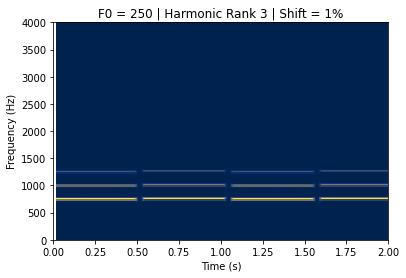

In [32]:
F0 = 250;
shift = .3e-2;
harm_rank = 16;
tot_harm = 18;

fs = 44100
atten = .5;
spacing = .03;
dur_sec = .5;
ramp_dur = 0.2;

###################################################################################################################
signal, time = pitch_discrim(F0 = 250);
get_spect(signal, fs, DR = 30, BW = 100, xlim = [0,2], ylim = [0,4e3], 
          colormap = 'cividis', title = 'F0 = 250 | Harmonic Rank 3 | Shift = 1%');
ipd.Audio(signal2, rate = fs)


## FM Harmonic Tone Complex Stimuli:
### Idea: 
   - Not a directly perceptual measure, ideally directly correlates with pitch coding
   - Won't be measuring FFR at discrete frequencies, rather measures the ability to track a moving pitch with varying harmonic rank. Could also add masking. 
   - See if Dave Axe's FFR findings in carbo chins (i.e. poorer FM coding) extend to pitch stimuli

### TODO:
   - Same as above
   - Math check...basic trig 
   - Spectrogram auto-title

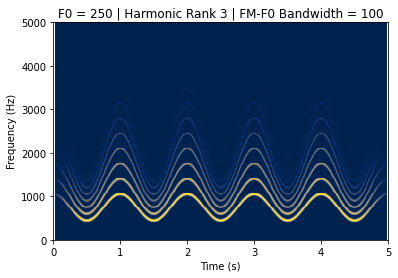

In [77]:
F0 = 250;
a_mod = 100;
rate_mod = 1;
harm_rank = 3;
tot_harm = 15;
fs = 44100
dur_sec = 5;
atten = .2;

signal2, time2 = hfm(phase = 'alt');
get_spect(sig, fs, DR = 200, BW = 100, xlim = [0,5], ylim = [0,5e3], 
           colormap = 'cividis', title = 'F0 = 250 | Harmonic Rank 3 | FM-F0 Bandwidth = 100');
#sound(signal2,fs,fname = 'FM.wav',savefile = 0)
ipd.Audio(signal2, rate = fs)